In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.cluster import KMeans

import heartdisease

rng = 104582

In [2]:
df_X, df_y = heartdisease.load_dataset()
df = pd.concat([df_X, df_y], axis=1)
print(df.head())

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak    IsMale  \
0 -1.433140   0.328423     0.567911  -0.551341  1.382928 -0.855375  0.515952   
1 -0.478484   0.964113     0.348389  -0.551341  0.754157  0.224868 -1.938163   
2 -1.751359  -0.024121     0.558175  -0.551341 -1.525138 -0.855375  0.515952   
3 -0.584556   0.259958     0.428555  -0.551341 -1.132156  0.679595 -1.938163   
4  0.051881   0.656800     0.385467  -0.551341 -0.581981 -0.855375  0.515952   

   HasExerciseAngina  ChestPainType_TA  ChestPainType_ATA  ChestPainType_NAP  \
0          -0.823556         -0.229679           2.075177          -0.532838   
1          -0.823556         -0.229679          -0.481887           1.876744   
2          -0.823556         -0.229679           2.075177          -0.532838   
3           1.214246         -0.229679          -0.481887          -0.532838   
4          -0.823556         -0.229679          -0.481887           1.876744   

   RestingECG_ST  RestingECG_LVH  IsST

In [3]:
kmeans = KMeans(n_clusters=7, random_state=rng).fit(df_X, df_y)
print(kmeans.cluster_centers_)

[[ 0.48156617 -0.0785411  -0.3892097   0.3706467  -0.26293336  1.04028177
   0.26638133  0.59254366 -0.22967867 -0.3518665  -0.1244341   0.10974633
   0.12252316 -0.86905588  3.68394199]
 [-0.55302131 -0.11819655  0.43901357 -0.3915373   0.64865388 -0.64857561
  -0.31314071 -0.72258411 -0.22967867  1.30345037 -0.53283777 -0.21700111
  -0.08331516  0.93232482 -0.27144836]
 [ 0.19331153  0.11254172  0.49176317 -0.11108467 -0.4021624   0.48060535
   0.11224508  0.68494676 -0.22967867 -0.4043999  -0.38680252 -0.49044933
   0.28634173 -0.6504704  -0.27144836]
 [-0.28514501 -0.22289073  0.38979737 -0.24941371  0.59361984 -0.35963476
  -0.33689628 -0.65012631 -0.22967867 -0.48188667  1.87674385 -0.29312056
   0.12520402  0.56337665 -0.27144836]
 [ 0.13950643  0.15882508  0.1834663   0.11705642  0.43550006  0.14239007
  -0.01755098 -0.55775599  4.35390879 -0.48188667 -0.53283777 -0.05055438
   0.35443676  0.00908754  0.07249863]
 [ 0.15691396 -0.05540576 -2.04754908  0.74714481 -0.6913999  -0.

In [4]:
class ClusterProjectionDataset(torch.utils.data.Dataset):
    def __init__(self, x1, x2):
        super().__init__()
        self.x1 = x2
        self.x2 = x2
        
#         self.kmeans = kmeans
        
#         nclusters = len(kmeans.cluster_centers_)
        
#         clusters = torch.as_tensor(kmeans.cluster_centers_).float()
        
#         arr = []
#         for i in range(nclusters):
#             tgt = torch.tile(clusters[i], (len(self.x), 1))
#             arr.append(F.pairwise_distance(self.x, tgt))
#         self.y = torch.cat(arr)
#         self.x = torch.tile(self.x, (nclusters, 1))
                
    def __getitem__(self, i):
        return self.x1[i // self.x2.shape[0]], self.x2[i % self.x2.shape[0]]
    
    def __len__(self):
        return self.x1.shape[0] * self.x2.shape[0]

In [5]:
class ClusterProjector2D(pl.LightningModule):
    def __init__(self, in_features, hidden_layer_size=1024):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(in_features, hidden_layer_size), 
            nn.ReLU(), 
            nn.Linear(hidden_layer_size, hidden_layer_size), 
            nn.ReLU(),
            nn.Linear(hidden_layer_size, 2)
        )

    def training_step(self, batch, batch_idx):
        x1, x2 = batch
        y = F.pairwise_distance(x1, x2)
        
        y1_pred = self.nn(x1)
        y2_pred = self.nn(x2)
        y_pred = F.pairwise_distance(y1_pred, y2_pred)
        return F.mse_loss(y_pred, y)
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [6]:
clusters = torch.as_tensor(kmeans.cluster_centers_).float()
x1 = torch.as_tensor(df_X.values).float()
x1 = torch.cat([x1, clusters])
x2 = x1
#x2 = clusters


dataset = ClusterProjectionDataset(x1, x2)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=8)

trainer = pl.Trainer(max_epochs=100)
projector = ClusterProjector2D(kmeans.n_features_in_)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [7]:
trainer.fit(model=projector, train_dataloaders=train_loader)


  | Name | Type       | Params
------------------------------------
0 | nn   | Sequential | 1.1 M 
------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.272     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
with torch.no_grad():
    y1 = projector.nn(x1).numpy()
    y2 = projector.nn(clusters).numpy()
    
cluster_indices = kmeans.predict(df_X)

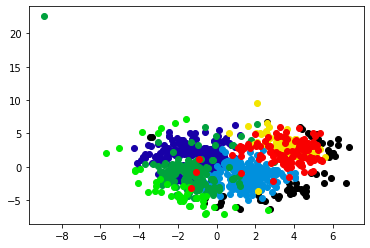

In [11]:
import matplotlib.cm as cm
plt.figure()

colors = ['g', 'b', 'c', 'm', 'y', 'k']

#plt.scatter(y1[:, 0], y1[:, 1])

for i in range(len(kmeans.cluster_centers_)):
    indices = np.argwhere(cluster_indices == i).flatten()
    yi = np.take(y1, indices, axis=0)
    color = cm.nipy_spectral(float(i) / len(kmeans.cluster_centers_))
    plt.scatter(yi[:, 0], yi[:, 1], color=color)

plt.scatter(y2[:, 0], y2[:, 1], color='r')
plt.show()

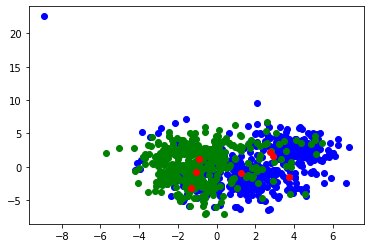

In [12]:
heart_disease_indices = np.argwhere(df_y.values == 0).flatten()
no_heart_disease_indices = np.argwhere(df_y.values == 1).flatten()

heart_disease = np.take(y1, heart_disease_indices, axis=0)
no_heart_disease = np.take(y1, no_heart_disease_indices, axis=0)

plt.figure()
plt.scatter(no_heart_disease[:, 0], no_heart_disease[:, 1], color='b')
plt.scatter(heart_disease[:, 0], heart_disease[:, 1], color='g')
plt.scatter(y2[:, 0], y2[:, 1], color='r')
plt.show()



<class 'list'>
[[53, 57, 59, 60, 62, 64, 67, 69, 71, 79, 80, 81, 82, 84, 88, 89, 90, 92, 93, 94, 95, 96, 98, 99, 106], [50, 51, 52, 54, 55, 56, 58, 61, 63, 65, 66, 68, 70, 72, 73, 74, 75, 76, 77, 78, 83, 85, 86, 87, 91, 97, 101, 113, 119, 121, 123, 126, 127, 133, 134, 138, 142, 146, 149], [0, 4, 5, 7, 10, 14, 15, 16, 17, 18, 19, 20, 21, 23, 26, 27, 28, 31, 32, 33, 36, 39, 40, 43, 44, 46, 48], [1, 2, 3, 6, 8, 9, 11, 12, 13, 22, 24, 25, 29, 30, 34, 35, 37, 38, 41, 42, 45, 47, 49], [100, 103, 104, 108, 110, 111, 112, 114, 115, 116, 120, 124, 128, 132, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148], [102, 105, 107, 109, 117, 118, 122, 125, 129, 130, 131, 135]]


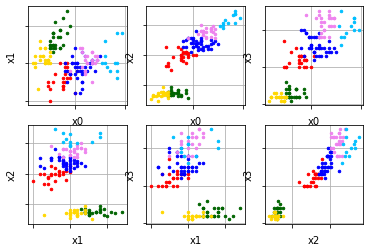

In [25]:
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
# load 4D data sample 'Iris'
sample_4d = read_sample(FAMOUS_SAMPLES.SAMPLE_IRIS)
# initialize 3 initial centers using K-Means++ algorithm
centers = kmeans_plusplus_initializer(sample_4d, 3).initialize()
# performs cluster analysis using X-Means
xmeans_instance = xmeans(sample_4d, centers)
xmeans_instance.process()
clusters = xmeans_instance.get_clusters()
print(type(clusters))
print(clusters)
# visualize obtained clusters in multi-dimensional space
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample_4d)
visualizer.show(max_row_size=3)